In [10]:
import pandas as pd
import sqlite3
import re

pd.set_option('display.expand_frame_repr', False)

def clean_column_name(name):
    """Clean column names to make them SQL compatible."""
    if isinstance(name, str):
        # Replace spaces and special characters with underscores
        clean_name = re.sub(r'[^a-zA-Z0-9_]', '_', name)
        # Ensure name doesn't start with a number
        if clean_name and clean_name[0].isdigit():
            clean_name = 'col_' + clean_name
        # Lowercase for consistency
        clean_name = clean_name.lower()
        return clean_name
    else:
        return f"column_{name}"

def convert_crime_data(filename, year):
    """
    Convert Colorado crime data Excel file to SQLite database with manual header offset.
    This script lets you manually set the header row and data start row.
    """
    # File paths
    excel_file = filename

    if 'colorado' in filename:
        db_file = 'colorado_crime_data_' + str(year) + '.db'
        table_name = 'colorado_crime_by_city'
        
    if 'georgia' in filename:
        db_file = 'georgia_crime_data_' + str(year) + '.db'
        table_name = 'georgia_crime_by_city'
    
    # ===== MANUAL CONFIGURATION =====
    # Set these values based on your inspection of the Excel file
    HEADER_ROW = 4  # Change this to the correct row index (0-based) that contains column headers
    DATA_START_ROW = 5  # Change this to the first row index (0-based) that contains actual data
    # ===============================
    
    print(f"\n\nReading Excel file: {excel_file}")
    print(f"Using row {HEADER_ROW} as column headers")
    print(f"Starting data from row {DATA_START_ROW}")
    
    try:
        # Read headers from specified row
        headers_df = pd.read_excel(excel_file, header=HEADER_ROW, nrows=0)
        column_names = [clean_column_name(col) for col in headers_df.columns]
        
        # Read data starting from the specified row
        # skiprows=DATA_START_ROW makes it skip all rows before DATA_START_ROW
        # header=None tells pandas not to use any row as header
        data_df = pd.read_excel(excel_file, skiprows=DATA_START_ROW, header=None)
        
        # Assign our clean column names
        data_df.columns = column_names[:len(data_df.columns)]
        
        # If data has more columns than our headers, add generic names
        if len(data_df.columns) > len(column_names):
            for i in range(len(column_names), len(data_df.columns)):
                data_df.columns.values[i] = f"column_{i}"
    except Exception as e:
        print(f"Error reading Excel file: {e}")
        # Try with a different engine
        try:
            headers_df = pd.read_excel(excel_file, header=HEADER_ROW, nrows=0, engine='openpyxl')
            column_names = [clean_column_name(col) for col in headers_df.columns]
            data_df = pd.read_excel(excel_file, skiprows=DATA_START_ROW, header=None, engine='openpyxl')
            data_df.columns = column_names[:len(data_df.columns)]
        except Exception as e2:
            try:
                headers_df = pd.read_excel(excel_file, header=HEADER_ROW, nrows=0, engine='xlrd')
                column_names = [clean_column_name(col) for col in headers_df.columns]
                data_df = pd.read_excel(excel_file, skiprows=DATA_START_ROW, header=None, engine='xlrd')
                data_df.columns = column_names[:len(data_df.columns)]
            except Exception as e3:
                print(f"Failed to read Excel file with all engines: {e3}")
                return False
    
    # Check if dataframe is empty
    if data_df.empty:
        print("Warning: Dataframe is empty - no data was read")
        return False
    
    print(f"Read {len(data_df)} rows of data")
    print("First 3 rows:")
    print(data_df.head(3))
    print("\nColumn names:")
    print(list(data_df.columns))
    
    # Remove rows where all values are NaN
    data_df = data_df.dropna(how='all')
    
    # Convert numeric columns to appropriate types
    """for col in data_df.columns:
        try:
            data_df[col] = pd.to_numeric(data_df[col], errors='coerce')
        except:
            pass  # Keep as is if conversion fails"""
    
    # Connect to SQLite database
    print(f"\nCreating SQLite database: {db_file}")
    conn = sqlite3.connect(db_file)
    
    # Write to SQLite database
    print(f"Creating table: {table_name}")
    data_df.to_sql(table_name, conn, if_exists='replace', index=False)
    
    # Get table info for verification
    cursor = conn.cursor()
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
    
    print(f"\nCreated table with {len(columns)} columns")
    print("Column structure:")
    for col in columns:
        print(f"  {col[1]} ({col[2]})")
    
    # Count rows
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    row_count = cursor.fetchone()[0]
    print(f"Rows inserted: {row_count}")
    
    # Close connection
    conn.close()
    
    print(f"\nConversion completed successfully!")
    print(f"Database file: {db_file}")
    print(f"Table name: {table_name}")
    print("\nYou can now use this database with SQL queries.")
    print(f"Example: SELECT * FROM {table_name} LIMIT 10;")
    
    return True

def read_db_file(db_file, table_name):
    """reads .db file and converts into python pd dataframe"""
    conn = sqlite3.connect(db_file)
    query = f"SELECT * FROM {table_name}"
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df


# List of .xls file extensions imported from FBI Crime Dta Explorer (UCR) program
# for Colorado from 2013-2019
xls_files_colorado = ["colorado_crime_data_2013.xls", "colorado_crime_data_2014.xls", "colorado_crime_data_2015.xls", "colorado_crime_data_2016.xls",
            "colorado_crime_data_2017.xls", "colorado_crime_data_2018.xls", "colorado_crime_data_2019.xls"]

# for Georgia from 2013-2019
xls_files_georgia = ["georgia_crime_data_2013.xls", "georgia_crime_data_2014.xls", "georgia_crime_data_2015.xls", "georgia_crime_data_2016.xls",
            "georgia_crime_data_2017.xls", "georgia_crime_data_2018.xls", "georgia_crime_data_2019.xls"]

# List of Converted database files from xls conversion
db_files_colorado = ["colorado_crime_data_2013.db", "colorado_crime_data_2014.db", "colorado_crime_data_2015.db", "colorado_crime_data_2016.db",
            "colorado_crime_data_2017.db", "colorado_crime_data_2018.db", "colorado_crime_data_2019.db"]

db_files_georgia = ["georgia_crime_data_2013.db", "georgia_crime_data_2014.db", "georgia_crime_data_2015.db", "georgia_crime_data_2016.db",
            "georgia_crime_data_2017.db", "georgia_crime_data_2018.db", "georgia_crime_data_2019.db"]


# Conversion for Colorado Data
start_year = 2013
db_table_name_colorado = 'colorado_crime_by_city'
dataframes_colorado = []

# Convert xls files into db databases
for file in xls_files_colorado:
    convert_crime_data(file, start_year)
    start_year += 1

start_year = 2013

# Convert databases into python pd dataframes
for db_file in db_files_colorado:
    df = read_db_file(db_file, db_table_name_colorado)
    df['year'] = start_year
    start_year += 1
    dataframes_colorado.append(df)

# Combine individual dataframes for 2013-2019 into a single df
combined_df_colorado = pd.concat(dataframes_colorado, ignore_index=True)
conn = sqlite3.connect('combined_colorado_crime_data.db')
combined_df_colorado.to_sql('combined_colorado_crime_data_table', conn, if_exists='replace', index=False)
conn.close()

print(f"\n\nCombined databases for years 2013-2019 into a single db")
print(f"Conversion completed successfully!")
print(f"Combined Database file: combined_colorado_crime_data.db")
print(f"Table name: combined_colorado_crime_data_table")
print("\nYou can now use this database with SQL queries.")
print(f"Example: SELECT * FROM combined_colorado_crime_data_table LIMIT 10;")


# Conversion for Georgia Data
start_year = 2013
db_table_name_georgia = 'georgia_crime_by_city'
dataframes_georgia = []

# Convert xls files into db databases
for file in xls_files_georgia:
    convert_crime_data(file, start_year)
    start_year += 1

start_year = 2013

# Convert databases into python pd dataframes
for db_file in db_files_georgia:
    df = read_db_file(db_file, db_table_name_georgia)
    df['year'] = start_year
    start_year += 1
    dataframes_georgia.append(df)

# Combine individual dataframes for 2013-2019 into a single df
combined_df_georgia = pd.concat(dataframes_georgia, ignore_index=True)
conn = sqlite3.connect('combined_georgia_crime_data.db')
combined_df_georgia.to_sql('combined_georgia_crime_data_table', conn, if_exists='replace', index=False)
conn.close()

print(f"\n\nCombined databases for years 2013-2019 into a single db")
print(f"Conversion completed successfully!")
print(f"Combined Database file: combined_georgia_crime_data.db")
print(f"Table name: combined_georgia_crime_data_table")
print("\nYou can now use this database with SQL queries.")
print(f"Example: SELECT * FROM combined_georgia_crime_data_table LIMIT 10;")



Reading Excel file: colorado_crime_data_2013.xls
Using row 4 as column headers
Starting data from row 5
Read 137 rows of data
First 3 rows:
     city  population  violent_crime  murder_and_nonnegligent_manslaughter  rape  robbery  aggravated_assault  property_crime  burglary  larceny__theft  motor_vehicle_theft  arson
0  Arvada    110792.0          163.0                                   0.0  33.0     34.0                96.0          2666.0     331.0          2138.0                197.0   22.0
1   Aspen      6685.0           14.0                                   0.0   5.0      0.0                 9.0           314.0      17.0           286.0                 11.0    0.0
2    Ault      1565.0            0.0                                   0.0   0.0      0.0                 0.0             2.0       0.0             0.0                  2.0    0.0

Column names:
['city', 'population', 'violent_crime', 'murder_and_nonnegligent_manslaughter', 'rape', 'robbery', 'aggravated_assault', 'p

In [11]:
# Aspen, Colorado Dataframe generation
db_name_colorado = 'combined_colorado_crime_data.db'
table_name_colorado = 'combined_colorado_crime_data_table'

print(f"\n\nCombined dataframe for Colorado reported crimes (2013-2019)")
print(combined_df_colorado)

# Parse Colorado dataframe for city='Aspen'
aspen_crime_df = combined_df_colorado[combined_df_colorado['city'] == 'Aspen'].copy()
print(f"\n\nQueried dataframe for city of Aspen reported crimes (2013-2019)")
print(aspen_crime_df)

# Alter Aspen dataframe to present values for crime rates (per 100,000 population)
aspen_crime_df['violent_crime_rate'] = (aspen_crime_df['violent_crime'] / aspen_crime_df['population']) * 100000

# Condense dataframe to only show relevant violent crime data
columns_to_drop = set(aspen_crime_df.columns) - set(['city', 'population', 'violent_crime', 'violent_crime_rate', 'year'])
aspen_crime_df = aspen_crime_df.drop(columns=columns_to_drop, errors='ignore')
print(f"\n\nQueried dataframe for city of Aspen violent crimes (2013-2019)")
print(aspen_crime_df)


# Atlanta, Georgia Dataframe generation
db_name_georgia = 'combined_georgia_crime_data.db'
table_name_georgia = 'combined_georgia_crime_data_table'

print(f"\n\nCombined dataframe for georgia reported crimes (2013-2019)")
print(combined_df_georgia)

# Parse Georgia dataframe for city='Atlanta'
atlanta_crime_df = combined_df_georgia[combined_df_georgia['city'] == 'Atlanta'].copy()
print(f"\n\nQueried dataframe for city of Atlanta reported crimes (2013-2019)")
print(atlanta_crime_df)

# Alter Atlanta dataframe to present values for crime rates (per 100,000 population)
atlanta_crime_df['violent_crime_rate'] = (atlanta_crime_df['violent_crime'] / atlanta_crime_df['population']) * 100000

# Condense dataframe to only show relevant violent crime data
columns_to_drop = set(atlanta_crime_df.columns) - set(['city', 'population', 'violent_crime', 'violent_crime_rate', 'year'])
atlanta_crime_df = atlanta_crime_df.drop(columns=columns_to_drop, errors='ignore')
print(f"\n\nQueried dataframe for city of Atlanta violent crimes (2013-2019)")
print(atlanta_crime_df)




Combined dataframe for Colorado reported crimes (2013-2019)
                                                  city  population  violent_crime  murder_and_nonnegligent_manslaughter   rape  robbery  aggravated_assault  property_crime  burglary  larceny__theft  motor_vehicle_theft  arson  year
0                                               Arvada    110792.0          163.0                                   0.0   33.0     34.0                96.0          2666.0     331.0          2138.0                197.0   22.0  2013
1                                                Aspen      6685.0           14.0                                   0.0    5.0      0.0                 9.0           314.0      17.0           286.0                 11.0    0.0  2013
2                                                 Ault      1565.0            0.0                                   0.0    0.0      0.0                 0.0             2.0       0.0             0.0                  2.0    0.0  2013
3         

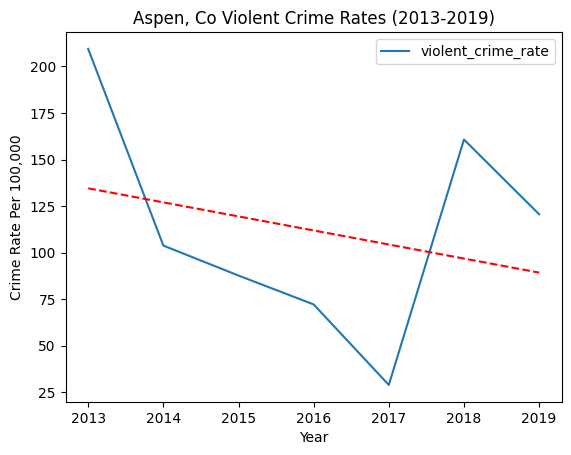

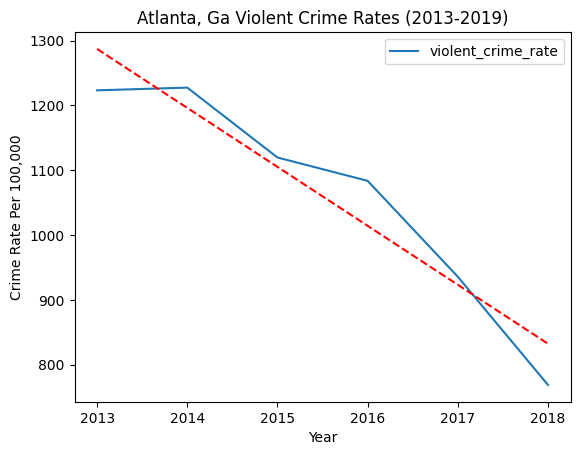

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Aspen dataframe visualization
# Assuming df is your DataFrame with a DatetimeIndex
aspen_crime_df.plot(x='year', y='violent_crime_rate')
plt.xlabel('Year')
plt.ylabel('Crime Rate Per 100,000')
plt.title('Aspen, Co Violent Crime Rates (2013-2019)')

# Calculating the line of best fit
z = np.polyfit(aspen_crime_df['year'], aspen_crime_df['violent_crime_rate'], 1)
p = np.poly1d(z)
plt.plot(aspen_crime_df['year'], p(aspen_crime_df['year']), "r--", label='Line of Best Fit')

plt_aspen_crime = plt

plt_aspen_crime.show()


# Atlanta dataframe visualization
# Assuming df is your DataFrame with a DatetimeIndex
atlanta_crime_df.plot(x='year', y='violent_crime_rate')
plt.xlabel('Year')
plt.ylabel('Crime Rate Per 100,000')
plt.title('Atlanta, Ga Violent Crime Rates (2013-2019)')

# Calculating the line of best fit
z = np.polyfit(atlanta_crime_df['year'], atlanta_crime_df['violent_crime_rate'], 1)
p = np.poly1d(z)
plt.plot(atlanta_crime_df['year'], p(atlanta_crime_df['year']), "r--", label='Line of Best Fit')

plt_atlanta_crime = plt

plt_atlanta_crime.show()

In [13]:
def convert_income_csv(filename):
    """
    Convert income data CSV file to SQLite database.
    """
    # Extract city name from filename
    city_name = None
    if '_median_individual_income.csv' in filename:
        city_name = filename.split('_median_individual_income.csv')[0]
    else:
        city_name = "unknown"
    
    # File paths
    csv_file = filename
    db_file = f'{city_name}_income_data.db'
    table_name = f'{city_name}_median_income'
    
    print(f"\n\nReading CSV file: {csv_file}")
    print(f"City identified as: {city_name}")
    
    try:
        # Read the CSV file
        data_df = pd.read_csv(csv_file)
        
        # Clean column names
        data_df.columns = [clean_column_name(col) for col in data_df.columns]
        
        # Verify expected columns exist
        expected_columns = ['date', 'median_individual_income']
        actual_columns = [clean_column_name(col) for col in data_df.columns]
        
        # Check if we have the expected columns
        if 'date' not in actual_columns:
            print(f"Error: Required column 'date' not found. Available columns: {actual_columns}")
            return False
        
        if 'median_individual_income' not in actual_columns:
            # Look for similar column names
            income_cols = [col for col in actual_columns if 'income' in col]
            if income_cols:
                print(f"Warning: Exact column 'median_individual_income' not found. Using '{income_cols[0]}' instead.")
                # Rename the column
                data_df = data_df.rename(columns={income_cols[0]: 'median_individual_income'})
            else:
                print(f"Error: Required column for income not found. Available columns: {actual_columns}")
                return False
        
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return False
    
    # Check if dataframe is empty
    if data_df.empty:
        print("Warning: Dataframe is empty - no data was read")
        return False
    
    print(f"Read {len(data_df)} rows of data")
    print("First 3 rows:")
    print(data_df.head(3))
    print("\nColumn names:")
    print(list(data_df.columns))
    
    # Remove rows where all values are NaN
    data_df = data_df.dropna(how='all')
    
    # Add a city name column
    data_df['city'] = city_name
    
    # Connect to SQLite database
    print(f"\nCreating SQLite database: {db_file}")
    conn = sqlite3.connect(db_file)
    
    # Create cities table
    print(f"Creating cities table")
    cursor = conn.cursor()
    
    # Check if cities table exists
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table' AND name='cities'")
    table_exists = cursor.fetchone()
    
    if not table_exists:
        cursor.execute('''
        CREATE TABLE cities (
            city_name TEXT PRIMARY KEY
        )
        ''')
    
    # Insert city into cities table
    cursor.execute(
        "INSERT OR IGNORE INTO cities (city_name) VALUES (?)",
        (city_name,)
    )
    
    # Write to SQLite database
    print(f"Creating table: {table_name}")
    data_df.to_sql(table_name, conn, if_exists='replace', index=False)
    
    # Create a view with yearly data in a more accessible format
    print("Creating yearly_income view for easier queries")
    view_name = f'{city_name}_yearly_income'
    
    cursor.execute(f'''
    CREATE VIEW IF NOT EXISTS {view_name} AS
    SELECT 
        city as city_name,
        date as year,
        median_individual_income as median_income
    FROM {table_name}
    ORDER BY year
    ''')
    
    # Get table info for verification
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
    
    print(f"\nCreated table with {len(columns)} columns")
    print("Column structure:")
    for col in columns:
        print(f"  {col[1]} ({col[2]})")
    
    # Count rows
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    row_count = cursor.fetchone()[0]
    print(f"Rows inserted: {row_count}")
    
    # Close connection
    conn.commit()
    conn.close()
    
    print(f"\nConversion completed successfully!")
    print(f"Database file: {db_file}")
    print(f"Table name: {table_name}")
    print(f"View name: {view_name}")
    print("\nYou can now use this database with SQL queries.")
    print(f"Example: SELECT * FROM {view_name};")
    
    return True


# Convert median individual income CSV files into databases
convert_income_csv('aspen_median_individual_income.csv')
convert_income_csv('atlanta_median_individual_income.csv')



Reading CSV file: aspen_median_individual_income.csv
City identified as: aspen
Read 7 rows of data
First 3 rows:
   date  median_individual_income
0  2013                     37130
1  2014                     38103
2  2015                     39496

Column names:
['date', 'median_individual_income']

Creating SQLite database: aspen_income_data.db
Creating cities table
Creating table: aspen_median_income
Creating yearly_income view for easier queries

Created table with 3 columns
Column structure:
  date (INTEGER)
  median_individual_income (INTEGER)
  city (TEXT)
Rows inserted: 7

Conversion completed successfully!
Database file: aspen_income_data.db
Table name: aspen_median_income
View name: aspen_yearly_income

You can now use this database with SQL queries.
Example: SELECT * FROM aspen_yearly_income;


Reading CSV file: atlanta_median_individual_income.csv
City identified as: atlanta
Read 7 rows of data
First 3 rows:
   date  median_individual_income
0  2013                     26

True

In [14]:
import os

def create_income_dataframes(db_file=None):
    """
    Create pandas DataFrames from the income database(s).
    """
    
    # If a specific database file is provided
    if db_file and os.path.exists(db_file):
        conn = sqlite3.connect(db_file)
        cursor = conn.cursor()
               
        # Extract city name from filename
        city = db_file.split('_income_data.db')[0]
        
        # Try to find the view or table
        view_name = f'{city}_yearly_income'
        cursor.execute(f"SELECT name FROM sqlite_master WHERE type='view' AND name='{view_name}'")

        
        if cursor.fetchone():
            # Use the view
            query = f"SELECT * FROM {view_name}"
            dataframe = pd.read_sql_query(query, conn)
        else:
            # Try the base table
            table_name = f'{city}_median_income'
            cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}'")
            
            if cursor.fetchone():
                query = f"SELECT date as year, median_individual_income as median_income, city as city_name FROM {table_name}"
                dataframe = pd.read_sql_query(query, conn)
        
        conn.close()
    
    return dataframe


atlanta_income_df = create_income_dataframes('atlanta_income_data.db')
print(atlanta_income_df)

aspen_income_df = create_income_dataframes('aspen_income_data.db')
print(aspen_income_df)

  city_name  year  median_income
0   atlanta  2013          26373
1   atlanta  2014          26782
2   atlanta  2015          27409
3   atlanta  2016          28657
4   atlanta  2017          30477
5   atlanta  2018          31660
6   atlanta  2019          34218
  city_name  year  median_income
0     aspen  2013          37130
1     aspen  2014          38103
2     aspen  2015          39496
3     aspen  2016          41576
4     aspen  2017          42468
5     aspen  2018          44358
6     aspen  2019          45535


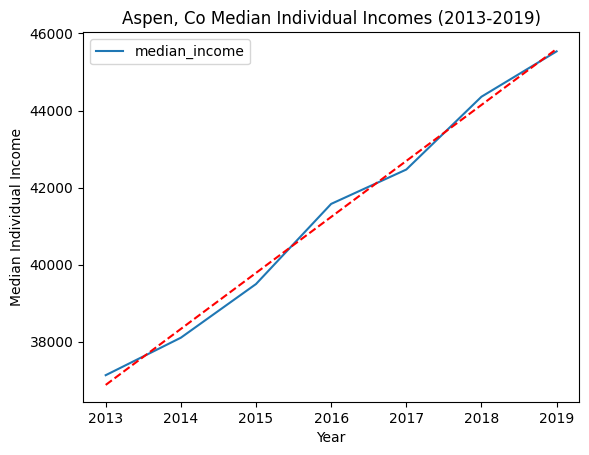

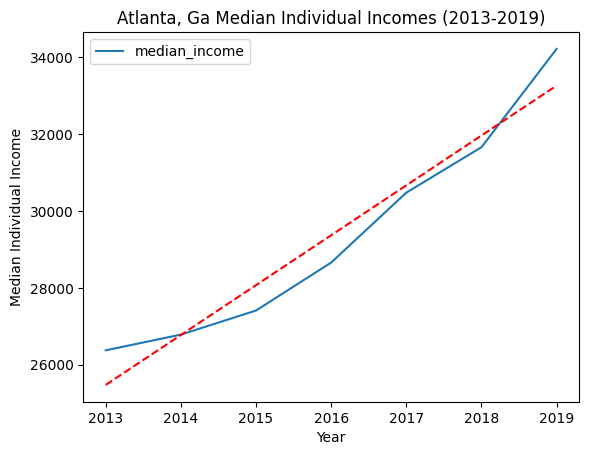

In [15]:
# Aspen dataframe visualization
# Assuming df is your DataFrame with a DatetimeIndex
aspen_income_df.plot(x='year', y='median_income')
plt.xlabel('Year')
plt.ylabel('Median Individual Income')
plt.title('Aspen, Co Median Individual Incomes (2013-2019)')

# Calculating the line of best fit
z = np.polyfit(aspen_income_df['year'], aspen_income_df['median_income'], 1)
p = np.poly1d(z)
plt.plot(aspen_income_df['year'], p(aspen_income_df['year']), "r--", label='Line of Best Fit')

plt_aspen_income = plt

plt_aspen_income.show()


# Atlanta dataframe visualization
# Assuming df is your DataFrame with a DatetimeIndex
atlanta_income_df.plot(x='year', y='median_income')
plt.xlabel('Year')
plt.ylabel('Median Individual Income')
plt.title('Atlanta, Ga Median Individual Incomes (2013-2019)')

# Calculating the line of best fit
z = np.polyfit(atlanta_income_df['year'], atlanta_income_df['median_income'], 1)
p = np.poly1d(z)
plt.plot(atlanta_income_df['year'], p(atlanta_income_df['year']), "r--", label='Line of Best Fit')

plt_atlanta_income = plt

plt_atlanta_income.show()

In [16]:
def convert_rent_csv(filename):
    """
    Convert rent data CSV file to SQLite database.
    """
    # Extract city name from filename
    city_name = None
    if '_rent_index.csv' in filename:
        city_name = filename.split('_rent_index.csv')[0]
    else:
        city_name = "unknown"
    
    # File paths
    csv_file = filename
    db_file = f'{city_name}_rent_data.db'
    table_name = f'{city_name}_rent_index'
    
    print(f"\n\nReading CSV file: {csv_file}")
    print(f"City identified as: {city_name}")
    
    try:
        # Read the CSV file
        data_df = pd.read_csv(csv_file)
        
        # Clean column names
        data_df.columns = [clean_column_name(col) for col in data_df.columns]
        
        # Verify expected columns exist
        expected_columns = ['year', 'rent_index']
        actual_columns = [clean_column_name(col) for col in data_df.columns]
        
        # Check if we have the expected columns
        if 'year' not in actual_columns:
            print(f"Error: Required column 'year' not found. Available columns: {actual_columns}")
            return False
        
        if 'rent_index' not in actual_columns:
            # Look for similar column names
            rent_cols = [col for col in actual_columns if 'rent' in col]
            if rent_cols:
                print(f"Warning: Exact column 'rent_index' not found. Using '{rent_cols[0]}' instead.")
                # Rename the column
                data_df = data_df.rename(columns={rent_cols[0]: 'rent_index'})
            else:
                print(f"Error: Required column for rent index not found. Available columns: {actual_columns}")
                return False
                        
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return False
    
    # Check if dataframe is empty
    if data_df.empty:
        print("Warning: Dataframe is empty - no data was read")
        return False
    
    print(f"Read {len(data_df)} rows of data")
    print("First 3 rows:")
    print(data_df.head(3))
    print("\nColumn names:")
    print(list(data_df.columns))
    
    # Remove rows where all values are NaN
    data_df = data_df.dropna(how='all')
    
    # Connect to SQLite database
    print(f"\nCreating SQLite database: {db_file}")
    conn = sqlite3.connect(db_file)
    
    # Create cities table
    print(f"Creating cities table")
    cursor = conn.cursor()
    
    # Write to SQLite database
    print(f"Creating table: {table_name}")
    data_df.to_sql(table_name, conn, if_exists='replace', index=False)
    
    # Create a view with yearly data in a more accessible format
    print("Creating yearly_rent view for easier queries")
    view_name = f'{city_name}_yearly_rent'
    
    cursor.execute(f'''
    CREATE VIEW IF NOT EXISTS {view_name} AS
    SELECT 
        year,
        rent_index
    FROM {table_name}
    ORDER BY year
    ''')
    
    # Get table info for verification
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
        
    print(f"\nCreated table with {len(columns)} columns")
    print("Column structure:")
    for col in columns:
        print(f"  {col[1]} ({col[2]})")
    
    # Count rows
    cursor.execute(f"SELECT COUNT(*) FROM {table_name}")
    row_count = cursor.fetchone()[0]
    print(f"Rows inserted: {row_count}")
    
    # Close connection
    conn.commit()
    conn.close()
    
    print(f"\nConversion completed successfully!")
    print(f"Database file: {db_file}")
    print(f"Table name: {table_name}")
    print(f"View name: {view_name}")
    print("\nYou can now use this database with SQL queries.")
    print(f"Example: SELECT * FROM {view_name};")
    
    return True


# Convert rent index CSV files into databases
convert_rent_csv('aspen_rent_index.csv')
convert_rent_csv('atlanta_rent_index.csv')



Reading CSV file: aspen_rent_index.csv
City identified as: aspen
Read 7 rows of data
First 3 rows:
   year  rent_index
0  2013     237.660
1  2014     252.558
2  2015     269.562

Column names:
['year', 'rent_index']

Creating SQLite database: aspen_rent_data.db
Creating cities table
Creating table: aspen_rent_index
Creating yearly_rent view for easier queries

Created table with 2 columns
Column structure:
  year (INTEGER)
  rent_index (REAL)
Rows inserted: 7

Conversion completed successfully!
Database file: aspen_rent_data.db
Table name: aspen_rent_index
View name: aspen_yearly_rent

You can now use this database with SQL queries.
Example: SELECT * FROM aspen_yearly_rent;


Reading CSV file: atlanta_rent_index.csv
City identified as: atlanta
Read 7 rows of data
First 3 rows:
   year  rent_index
0  2013     209.305
1  2014     219.812
2  2015     229.535

Column names:
['year', 'rent_index']

Creating SQLite database: atlanta_rent_data.db
Creating cities table
Creating table: atlan

True

In [17]:
def create_rent_dataframes(db_file=None):
    """
    Create pandas DataFrames from the rent index database(s).
    """
    
    # If a specific database file is provided
    if db_file and os.path.exists(db_file):
        conn = sqlite3.connect(db_file)
        cursor = conn.cursor()
               
        # Extract city name from filename
        city = db_file.split('_rent_data.db')[0]
        
        # Try to find the view or table
        view_name = f'{city}_yearly_rent'
        cursor.execute(f"SELECT name FROM sqlite_master WHERE type='view' AND name='{view_name}'")

        
        if cursor.fetchone():
            # Use the view
            query = f"SELECT * FROM {view_name}"
            dataframe = pd.read_sql_query(query, conn)
        else:
            # Try the base table
            table_name = f'{city}_rent_index'
            cursor.execute(f"SELECT name FROM sqlite_master WHERE type='table' AND name='{table_name}'")
            
            if cursor.fetchone():
                query = f"SELECT year, rent_index FROM {table_name}"
                dataframe = pd.read_sql_query(query, conn)
        
        conn.close()
    
    return dataframe


atlanta_rent_df = create_rent_dataframes('atlanta_rent_data.db')
print(atlanta_rent_df)

aspen_rent_df = create_rent_dataframes('aspen_rent_data.db')
print(aspen_rent_df)

   year  rent_index
0  2013     209.305
1  2014     219.812
2  2015     229.535
3  2016     241.154
4  2017     256.121
5  2018     268.112
6  2019     282.115
   year  rent_index
0  2013     237.660
1  2014     252.558
2  2015     269.562
3  2016     290.046
4  2017     303.287
5  2018     316.309
6  2019     326.164


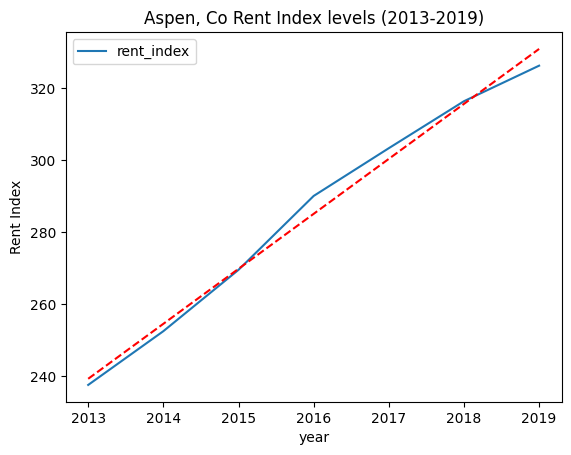

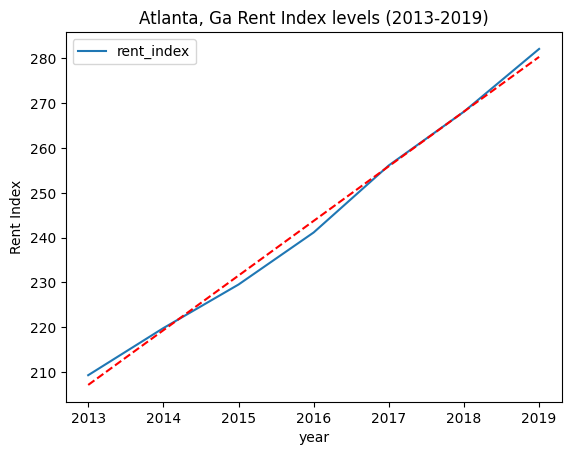

In [18]:
# Aspen dataframe visualization
# Assuming df is your DataFrame with a DatetimeIndex
aspen_rent_df.plot(x='year', y='rent_index')
plt.xlabel('year')
plt.ylabel('Rent Index')
plt.title('Aspen, Co Rent Index levels (2013-2019)')

# Calculating the line of best fit
z = np.polyfit(aspen_rent_df['year'], aspen_rent_df['rent_index'], 1)
p = np.poly1d(z)
plt.plot(aspen_rent_df['year'], p(aspen_rent_df['year']), "r--", label='Line of Best Fit')

plt_aspen_rent = plt

plt_aspen_rent.show()

# Atlanta dataframe visualization
# Assuming df is your DataFrame with a DatetimeIndex
atlanta_rent_df.plot(x='year', y='rent_index')
plt.xlabel('year')
plt.ylabel('Rent Index')
plt.title('Atlanta, Ga Rent Index levels (2013-2019)')

# Calculating the line of best fit
z = np.polyfit(atlanta_rent_df['year'], atlanta_rent_df['rent_index'], 1)
p = np.poly1d(z)
plt.plot(atlanta_rent_df['year'], p(atlanta_rent_df['year']), "r--", label='Line of Best Fit')

plt_atlanta_rent = plt

plt_atlanta_rent.show()